# Getting Started: Region-Level Classification (Task 1)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MTNeuro/MTNeuro/blob/main/notebooks/task1_getting_started.ipynb)

### We will use the 🔄 icon to indicate places that you can change.

#### Install the required packages

In [ ]:
!pip install 'intern[cloudvolume]' scikit-learn timm pretrainedmodels efficientnet_pytorch segmentation-models-pytorch
!git clone https://github.com/MTNeuro/MTNeuro && cd MTNeuro && pip install .
%cd MTNeuro

#### Importing required packages

In [2]:
## Import libraries
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json as json
from tqdm.notebook import tqdm

## Pytorch imports
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

## BossDB library and MTNeuro dataset loader
from intern import array
from MTNeuro.bossdbdataset import BossDBDataset               
from MTNeuro.trainer import Trainer
import MTNeuro.models

from sklearn.metrics import confusion_matrix

## Task Overview
![image.png](https://mtneuro.github.io/images/tasks.png)

#### Dataset Description

The original brain data is 5805 by 1420 by 720 pixels and was taken using x-ray microtomography [[1]](#1). You can view the raw data and regions of interest using Neuroglancer on the [BossDB](https://bossdb.org/project/prasad2020) website.

The MTNeuro dataset consists of four annotated cubes of 256 by 256 by 360 pixels from the cortex (CTX), striatum (STR), thalamus (VP), and zona incerta (ZI) as described in the MTNeuro paper [[2]](#2). The slices in each cube are labeled as 0 (CTX), 1 (STR), 2 (VP), or 3 (ZI) and are partitioned into train/test subvolumes as follows:

|        | Train | Buffer  | Test    |
|:------:|:-----:|:-------:|:-------:|
| Slices | 0-299 | 300-309 | 310-359 |

The train slices of each cube are concatenated to form the training set of subvolume **A** (blue), and the same is done for the test slices. A 10 slice gap is kept between the training and test slices to avoid structural overlap. This process is repeated to generate three other subvolumes **B**, **C**, and **D** (yellow) for this task using different cubes in the original dataset.


<a id="1">[1]</a> Prasad, J. A., Balwani, A. H., Johnson, E. C., Miano, J. D., Sampathkumar, V., De Andrade, V., ... & Dyer, E. L. (2020). A three-dimensional thalamocortical dataset for characterizing brain heterogeneity. Scientific Data, 7(1), 1-7.

<a id="2">[2]</a> Quesada, J., Sathidevi, L., Liu, R., Ahad, N., Jackson, J.M., Azabou, M., ... & Dyer, E. L. (2022). MTNeuro: A Benchmark for Evaluating Representations of Brain Structure Across Multiple Levels of Abstraction. Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track.

#### Task 1 Objectives

Task 1 is split into three separate classification tasks.
1. C1: prediction of the origin brain region of a sample within a same subvolume
2. C2: evaluation of generalization of the prediction with different test subvolumes
3. C3: evaluation of performance of prediction when trained with more subvolumes

The training and testing sets of each task is shown below:
| Task | Train Set | Test Set |
|:----:|-----------|----------|
| C1   | A         | A        |
| C2   | A         | B, C, D  |
| C3   | A, B      | C, D     |

All train sets (256x256x300) are generated as described above, with the exception of task C3 which uses all of subvolume **B** (256x256x360) for training. The test sets all have size 256x256x50.

**We will focus on task C1 in this notebook.**

## Loading Data

Loading data for for MTNeuro Benchmark is easy. The coordinates for the slices used in the train, validation, and test sets are stored in the task config file which can be found [here](https://github.com/MTNeuro/MTNeuro/tree/main/MTNeuro/taskconfig).

In [3]:
root = "./MTNeuro/"

## Load the task config for 2D 4-class setting that specifies the x, y ranges for each cube
with open(os.path.join(root, f"taskconfig/task1.json")) as file:
    task_config = json.load(file)
    
print("Task name:", task_config['name'])

Task name: task1


#### Load the Data using the BossDBDataset class

The MTNeuro benchmark provides the `BossDBDataset` class for convenient data loading. It takes the parameters specified by the task config and downloads the relevant slices.

In [4]:
## Use transforms.ToTensor() if no other transforms are needed
transform = transforms.ToTensor()

## Load diff splits using mode='etc'
train_data = BossDBDataset(task_config, None, mode='train', image_transform=transform, mask_transform=transform)
val_data = BossDBDataset(task_config, None, mode='val', image_transform=transform, mask_transform=transform)
test_data = BossDBDataset(task_config, None, mode="test", image_transform=transform, mask_transform=transform)

In [5]:
print("Number of training samples", len(train_data))
print("Number of validation samples", len(train_data))
print("Number of test samples", len(train_data))

Number of training samples 1076
Number of validation samples 1076
Number of test samples 1076


#### Visualize a slice from the train data

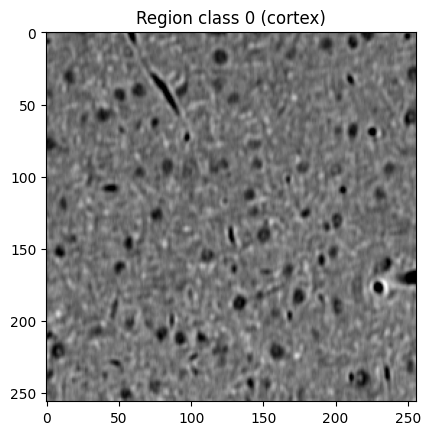

In [6]:
## Access the first slice of the training data
x, y = train_data[0]

im = plt.imshow(x.squeeze(), cmap='gray')
plt.title(f"Region class {y} (cortex)")
plt.show()

#### Create a collage of random slices from the training data

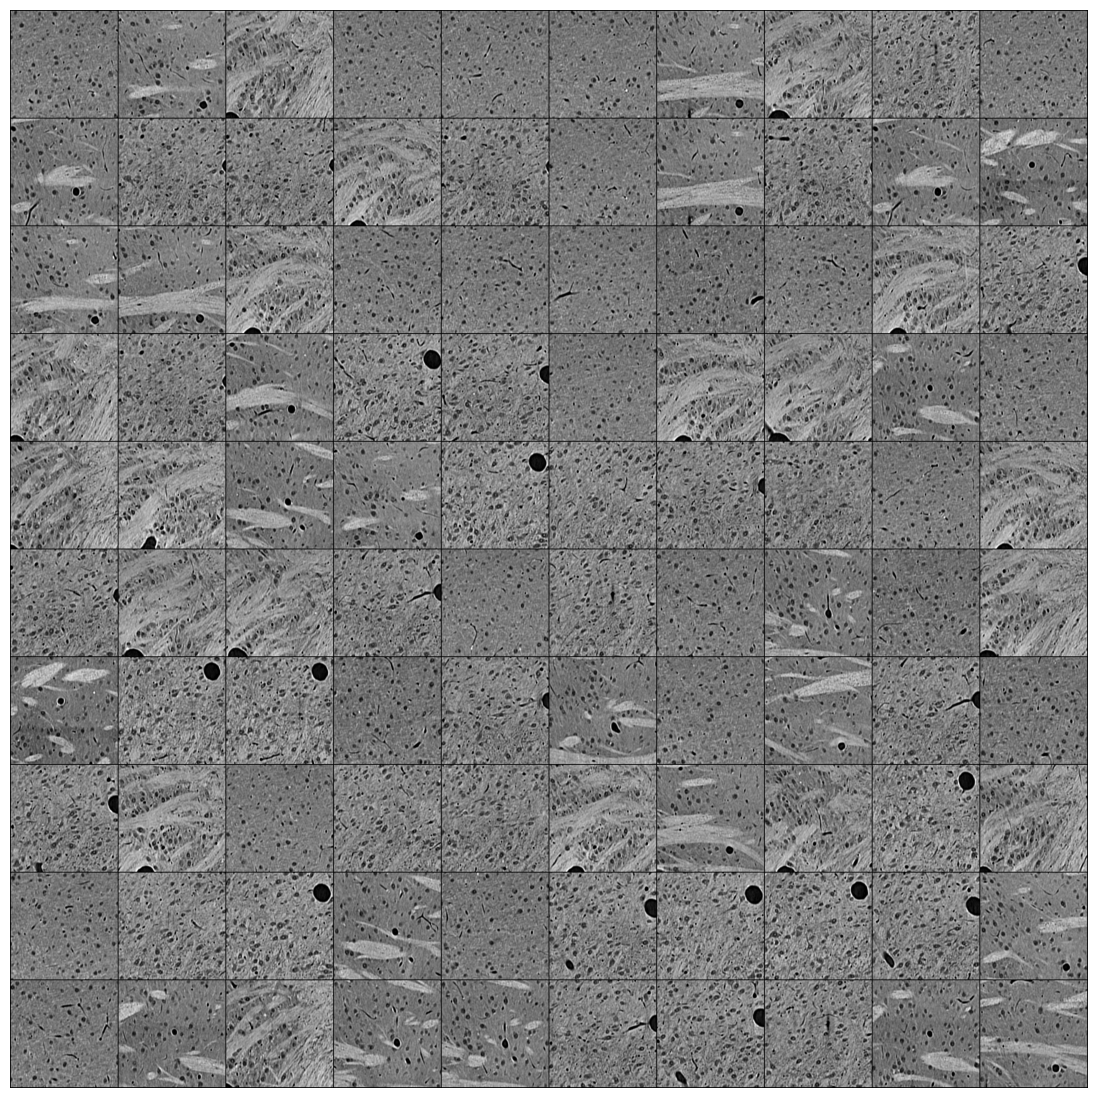

In [7]:
import random

## Reshape data and select a random subset of 100 slices
reshaped_data = [data[0][0] for data in train_data]
random_samples_from_data = random.sample(reshaped_data,100)
    
grid_img = make_grid(torch.stack(random_samples_from_data).unsqueeze(1), nrow=10)
plt.figure(figsize=(14,14))
plt.axis('off')
plt.imshow(grid_img[0], cmap='gray')
plt.show()

## Building the model 

We use JSON configurations for individual network runs which can be found in the MTNeuro repository [here](https://github.com/MTNeuro/MTNeuro/tree/main/MTNeuro/networkconfig). All of the networks for task 1 use ResNet-18 as a backbone [[3]](#3).

The prepared models relevant to task 1 are:
- SUP_ResNet-18_2D: the base ResNet-18 architecture trained using supervised learning
- SSL_BYOL_ResNet-18_2D: ResNet-18 trained with the self-supervised BYOL framework [[4]](#4)
- SSL_MYOWMerged_ResNet-18_2D: ResNet-18 trained with the self-supervised MYOW framework [[5]](#5)
- SSL_MYOW_ResNet-18_2D: ResNet-18 trained with a modified self-supervised MYOW framework [[2]](#2)

We will use the supervised Resnet-18 architecture as an example model to demonstrate data access and training.

<a id="3">[3]</a> He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

<a id="4">[4]</a> Grill, J. B., Strub, F., Altché, F., Tallec, C., Richemond, P., Buchatskaya, E., ... & Valko, M. (2020). Bootstrap your own latent-a new approach to self-supervised learning. Advances in neural information processing systems, 33, 21271-21284.

<a id="5">[5]</a> Azabou, M., Azar, M. G., Liu, R., Lin, C. H., Johnson, E. C., Bhaskaran-Nair, K., ... & Dyer, E. L. (2021). Mine your own view: Self-supervised learning through across-sample prediction. arXiv preprint arXiv:2102.10106

In [8]:
model_config = "SUP_ResNet-18_2D"

## Load the network config for the 2D model for 4-class setting, with the batch size and model config information
with open(root + f"networkconfig/{model_config}.json") as file:
    network_config = json.load(file)

print("Learning rate is", network_config["learning_rate"])
print("Number of epochs is", network_config["epochs"])
print("Optimizer is", network_config["optimizer"])

Learning rate is 0.01
Number of epochs is 1
Optimizer is SGD


🔄 You can access and change the parameters in the `network_config` dictionary.

In [9]:
## Specify the device to run the model on
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
## Load the model with the configuration specified through the network config file
model = MTNeuro.models.resnet_xray_classifier(
                resnet_model = 'resnet18',
                depth=network_config['in_channels'],
                num_classes=network_config['classes'],
                ).to(device)

In [10]:
## Load the training and validation data into PyTorch dataloaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=network_config['batch_size'],
                              shuffle=True)
validation_dataloader = DataLoader(dataset=val_data,
                                   batch_size=network_config['batch_size'],
                                   shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=network_config['batch_size'],
                             shuffle=True)

#### Set the Loss criteria and the Optimizer

For Task 1 C1, we will use cross entropy loss and the SGD optimizer.

In [11]:
criterion = torch.nn.CrossEntropyLoss()

if network_config["optimizer"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=network_config["learning_rate"])
if network_config["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=network_config["learning_rate"], betas=(network_config["beta1"],network_config["beta2"]))

## Train the model

We will train the model using the `Trainer` class provided by MTNeuro.

In [12]:
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=train_dataloader,
                  validation_DataLoader=validation_dataloader,
                  epochs=network_config["epochs"],
                  notebook=True)

training_losses, validation_losses, lr_rates = trainer.run_trainer()

Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/135 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

## Evaluate the model

We test the model on the test set and compute its accuracy.

In [13]:
def predict(img, model, device):
    """Predicts the class of a slice
    """
    model.eval()
    x = img.to(device)                     # send input to device
    with torch.inference_mode():
        out = model(x)                     # model forward pass

    out_argmax = torch.argmax(out, dim=1)  # perform softmax on outputs
    return out_argmax

In [14]:
## Make predictions on the test data
y_pred = torch.empty(0)
y_true = torch.empty(0)

for x, y in test_dataloader:
    pred_class = predict(x, model, device).to('cpu')
    y_pred = torch.cat((y_pred, pred_class))
    y_true = torch.cat((y_true, y))

acc = torch.sum((y_pred==y_true)) / y_true.shape[0]
print(f"Test Accuracy = {acc:0.4f}")

Test Accuracy = 0.6500


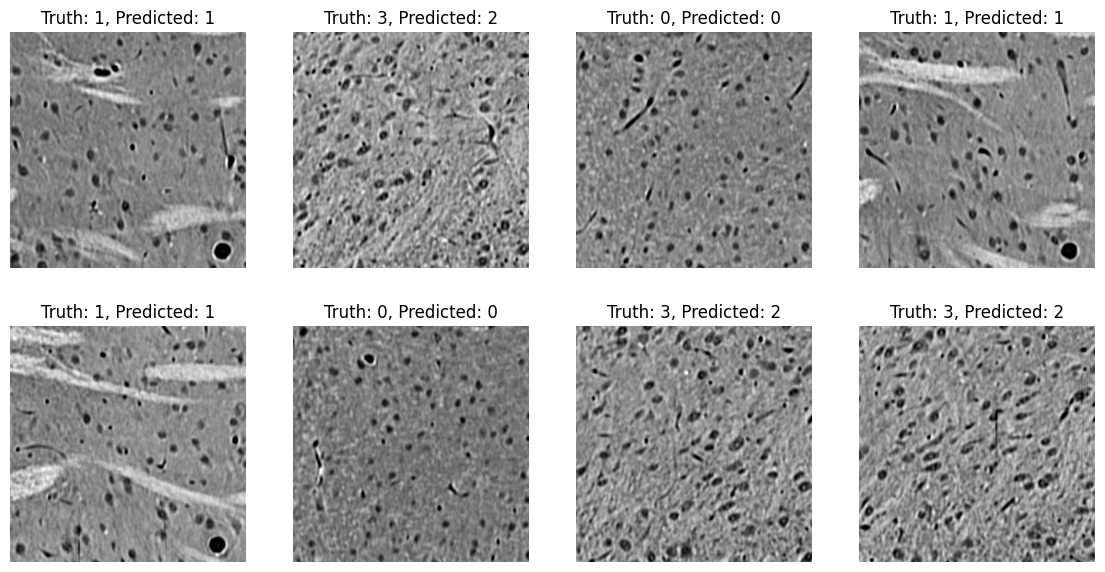

In [15]:
## Predictions on one batch
x, y = next(iter(test_dataloader))
pred = predict(x, model, device).to('cpu')

plt.figure(figsize=(14,7))
for i, j in enumerate(x):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.title(f"Truth: {y[i].item()}, Predicted: {pred[i].item()}")
    plt.imshow(x[i].squeeze(), cmap='gray')
plt.show();

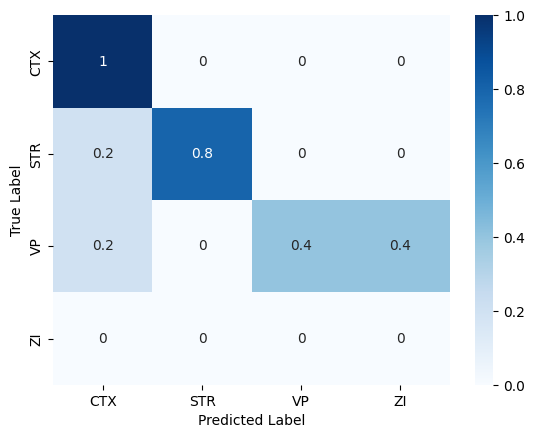

In [16]:
## Visualize the confusion matrix
label_names = ['CTX', 'STR', 'VP', 'ZI']

cm = confusion_matrix(y_pred, y_true, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5,1.5,2.5,3.5], label_names)
plt.yticks([0.5,1.5,2.5,3.5], label_names)
plt.show();